<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/Hybrid_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import uuid
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Concatenate, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

SEQ_LENGTH = 10
EMBEDDING_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 15
TEST_SIZE = 0.2

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/contrastive_results4/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

Mounted at /content/drive


In [3]:
def load_and_preprocess_data(data_path, max_users=180):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]

    for user in user_dirs:
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])

        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()

    scaler = MinMaxScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler

In [21]:
df, user_ids, scaler = load_and_preprocess_data(DATA_PATH, max_users=180)

In [22]:
# =====================
# Создание последовательностей
# =====================

def create_sequences_and_save(df, user_ids, seq_length, test_size=0.2, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in df.groupby('user'):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def process_chunk(data, is_train=True):
            window_size = seq_length + 1
            data_values = data[features].values
            if len(data_values) < window_size:
                print(f"Недостаточно данных для пользователя {uid}. Пропуск.")
                return

            # окна для последовательностей (X: все шаги, кроме последнего; y: целевые значения со смещением)
            X = np.lib.stride_tricks.sliding_window_view(data_values, (window_size, data_values.shape[1]))
            X = X.squeeze(axis=1)
            X = X[:, :-1]
            y = data[targets].values[seq_length:]

            chunk_size = 1000
            for i in range(0, len(X), chunk_size):
                save_chunk(X[i:i+chunk_size], y[i:i+chunk_size], is_train)

        def save_chunk(X, y, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X,
                y=y,
                user_id=uid
            )

        process_chunk(user_df.iloc[:split_idx], is_train=True)
        process_chunk(user_df.iloc[split_idx-seq_length:], is_train=False)

In [23]:
import shutil
shutil.rmtree(SEQ_SAVE_PATH, ignore_errors=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

In [4]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test, users_train, users_test = [], [], [], [], [], []

    for fname in sorted(os.listdir(save_path)):
        if not fname.endswith('.npz'):
            continue

        if 'train' in fname:
            split_type = 'train'
        elif 'test' in fname:
            split_type = 'test'
        else:
            continue

        uid = int(fname.split('_')[1])
        data = np.load(os.path.join(save_path, fname))
        X = data['X']
        y = data['y']

        if split_type == 'train':
            X_train.append(X)
            y_train.append(y)
            users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X)
            y_test.append(y)
            users_test.append(np.full(len(X), uid))

    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [5]:
X_train, X_test, y_train, y_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)
print("X_train shape - ", X_train.shape)

KeyboardInterrupt: 

In [5]:
# контрастивное обучение для эмбеддингов пользователей


class ContrastiveModel(tf.keras.Model):
    def __init__(self, num_users, embedding_dim):
        super().__init__()
        self.embedding = Embedding(num_users, embedding_dim)
        self.dense = Dense(embedding_dim, activation='tanh')

    def call(self, inputs):
        user_id = inputs
        user_emb = self.embedding(user_id)
        return self.dense(user_emb)

    def train_step(self, data):
        users, _ = data
        with tf.GradientTape() as tape:
            embeddings = self(users)

            anchor = embeddings[:-1]
            positive = embeddings[1:]
            distances = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
            loss = self.compiled_loss(tf.zeros_like(distances), distances)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}

In [8]:
contrastive_model = ContrastiveModel(num_users=180, embedding_dim=EMBEDDING_DIM)
contrastive_model.compile(optimizer=Adam(0.001), loss=tf.keras.losses.MeanSquaredError())
contrastive_model.fit(users_train, np.zeros(len(users_train)), epochs=3, batch_size=BATCH_SIZE)
user_embeddings = contrastive_model.predict(np.unique(users_train))

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


310649/310649 ━━━━━━━━━━━━━━━━━━━━ 493s 2ms/step - loss: 3.1704e-08
Epoch 2/3
310649/310649 ━━━━━━━━━━━━━━━━━━━━ 494s 2ms/step - loss: 1.3774e-13
Epoch 3/3
310649/310649 ━━━━━━━━━━━━━━━━━━━━ 492s 2ms/step - loss: 7.1813e-14
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [17]:
from tensorflow.keras.utils import Sequence

class CombinedDataGenerator(Sequence):
    def __init__(self, X, users, y, user_embeddings, batch_size=64):
        super().__init__()
        self.X = X
        self.users = users
        self.y = y
        self.user_embeddings = user_embeddings
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.X))

        X_batch = self.X[start:end]
        user_batch = self.users[start:end]
        y_batch = self.y[start:end]

        user_emb_batch = self.user_embeddings[user_batch]
        user_emb_expanded = np.repeat(user_emb_batch[:, np.newaxis, :], X_batch.shape[1], axis=1)

        combined_X = np.concatenate([X_batch, user_emb_expanded], axis=-1)

        return (combined_X.astype(np.float32), user_batch.astype(np.int32)), y_batch.astype(np.float32)

In [18]:
# =====================
# построение hybrid LSTM
# =====================

def build_lstm_model(seq_length, embedding_dim, num_features, num_users):
    seq_input = Input(shape=(seq_length, num_features), name='seq_input')
    user_input = Input(shape=(1,), dtype=tf.int32, name='user_input')

    user_emb = Embedding(num_users, embedding_dim, name='user_embedding')(user_input)
    user_emb = Reshape((embedding_dim,), name='user_emb_reshape')(user_emb)

    lstm_out = LSTM(LSTM_UNITS, return_sequences=False, name='lstm_layer')(seq_input)

    combined = Concatenate(name='concat')([lstm_out, user_emb])
    dense_out = Dense(64, activation='relu', name='dense_1')(combined)
    dense_out = Dense(32, activation='relu', name='dense_2')(dense_out)
    final_output = Dense(2, activation='linear', name='final_output')(dense_out)

    model = Model(inputs=[seq_input, user_input], outputs=final_output)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [19]:
train_generator = CombinedDataGenerator(X_train, users_train, y_train, user_embeddings, batch_size=BATCH_SIZE)
val_generator = CombinedDataGenerator(X_test, users_test, y_test, user_embeddings, batch_size=BATCH_SIZE)

In [20]:
checkpoint = ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH, 'best_model3.keras'),
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


In [21]:
model = build_lstm_model(
    seq_length=SEQ_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    num_features=X_train.shape[2] + EMBEDDING_DIM,
    num_users= 180
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 10, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 16)     │      2,880 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 64)        │     22,528 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb_reshape    │ (None, 16)        │          0 │ user_embedding[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 80)        │          0 │ lstm_layer[0][0], │
│ (Concatenate)       │                   │            │ user_emb_reshape… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      5,184 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 2)         │         66 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,738 (127.88 KB)

 Trainable params: 32,738 (127.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/15
310644/310649 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6646e-04 - mae: 0.0065
Epoch 1: val_loss improved from inf to 0.00002, saving model to /content/drive/My Drive/Colab Notebooks/contrastive_results4/best_model3.keras
310649/310649 ━━━━━━━━━━━━━━━━━━━━ 1744s 6ms/step - loss: 2.6646e-04 - mae: 0.0065 - val_loss: 1.8573e-05 - val_mae: 0.0014
Epoch 2/15
310649/310649 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1261e-05 - mae: 0.0019
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to /content/drive/My Drive/Colab Notebooks/contrastive_results4/best_model3.keras
310649/310649 ━━━━━━━━━━━━━━━━━━━━ 1744s 6ms/step - loss: 1.1261e-05 - mae: 0.0019 - val_loss: 5.9468e-06 - val_mae: 7.9721e-04
Epoch 3/15
126751/310649 ━━━━━━━━━━━━━━━━━━━━ 15:24 5ms/step - loss: 8.5924e-06 - mae: 0.0015

In [ ]:
def predict_with_generator(model, X, users, user_embeddings, batch_size=64):
    preds = []
    generator = CombinedDataGenerator(X, users, np.zeros((len(users), 2)), user_embeddings, batch_size=batch_size)
    for (X_batch, user_batch), _ in generator:
        batch_preds = model.predict([X_batch, user_batch], verbose=0)
        preds.append(batch_preds)
    return np.vstack(preds)

model.load_weights(os.path.join(SAVE_PATH, 'best_model.keras'))
y_pred = predict_with_generator(model, X_test, users_test, user_embeddings, batch_size=BATCH_SIZE)

In [ ]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.linalg.norm(preds - targets, axis=-1).mean()
    distances = np.linalg.norm(preds[:, None] - targets[:, :, None], axis=-1)
    acc1 = np.mean(np.argmin(distances, axis=-1) == 0)
    return ade, fde, acc1

ade, fde, acc1 = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, Accuracy@1: {acc1:.4f}")

In [13]:
model = build_lstm_model(SEQ_LENGTH, EMBEDDING_DIM, X_train_combined.shape[2], len(user_ids))
model.summary()

NameError: name 'X_train_combined' is not defined

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

NameError: name 'model' is not defined

In [ ]:
def predict_with_generator(model, X, users, user_embeddings, batch_size=64):
    preds = []
    generator = CombinedDataGenerator(X, users, np.zeros((len(users), 2)), user_embeddings, batch_size=batch_size)
    for (X_batch, user_batch), _ in generator:
        batch_preds = model.predict([X_batch, user_batch], verbose=0)
        preds.append(batch_preds)
    return np.vstack(preds)

# загрузка лучших весов и предсказание
model.load_weights(os.path.join(SAVE_PATH, 'best_model.keras'))
y_pred = predict_with_generator(model, X_test, users_test, user_embeddings, batch_size=BATCH_SIZE)

In [ ]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.linalg.norm(preds[:, -1] - targets[:, -1], axis=-1).mean() if preds.ndim == 3 else np.linalg.norm(preds - targets, axis=-1).mean()
    distances = np.linalg.norm(preds[:, None] - targets[:, :, None], axis=-1)
    acc1 = np.mean(np.argmin(distances, axis=-1) == 0)
    return ade, fde, acc1

ade, fde, acc1 = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, Accuracy@1: {acc1:.4f}")

In [ ]:
from tensorflow.keras.utils import Sequence

class CombinedDataGenerator(Sequence):
    def __init__(self, X, users, y, user_embeddings, batch_size=64):
        self.X = X
        self.users = users
        self.y = y
        self.user_embeddings = user_embeddings
        self.batch_size = batch_size
        self.seq_length = X.shape[1]

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_users = self.users[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_embs = self.user_embeddings[batch_users]
        embs_expanded = np.repeat(batch_embs[:, np.newaxis, :], self.seq_length, axis=1)
        combined = np.concatenate([batch_X, embs_expanded], axis=-1)

        return [combined, batch_users], batch_y

In [29]:
def combine_features(X, users, embeddings):
    if X.ndim != 3:
        raise ValueError(f"error shape X: {X.shape}. (N, seq_length, features).")
    user_embs = embeddings[users]
    embeddings_expanded = np.repeat(user_embs[:, np.newaxis, :], SEQ_LENGTH, axis=1)
    combined = np.concatenate([X, embeddings_expanded], axis=-1)
    print(f"X shape: {X.shape}, embeddings_expanded shape: {embeddings_expanded.shape}, combined shape: {combined.shape}")
    return combined

In [ ]:
X_train_combined = combine_features(X_train, users_train, user_embeddings)
X_test_combined = combine_features(X_test, users_test, user_embeddings)

In [15]:
# =====================
# обучение с callbacks
# =====================

checkpoint = ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH, 'best_model.keras'),
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [X_train_combined, users_train],
    y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5
1357/1363 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - mae: 0.0366
Epoch 1: val_loss improved from inf to 0.00039, saving model to /content/drive/My Drive/Colab Notebooks/contrastive_results4/best_model.keras
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0108 - mae: 0.0365 - val_loss: 3.9212e-04 - val_mae: 0.0145
Epoch 2/5
1357/1363 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9027e-05 - mae: 0.0037
Epoch 2: val_loss improved from 0.00039 to 0.00033, saving model to /content/drive/My Drive/Colab Notebooks/contrastive_results4/best_model.keras
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 4.9047e-05 - mae: 0.0037 - val_loss: 3.3210e-04 - val_mae: 0.0136
Epoch 3/5
1359/1363 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3470e-05 - mae: 0.0038
Epoch 3: val_loss improved from 0.00033 to 0.00029, saving model to /content/drive/My Drive/Colab Notebooks/contrastive_results4/best_model.keras
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.3329e-05 - mae: 0.0038 - val

In [16]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.linalg.norm(preds[:, -1] - targets[:, -1], axis=-1).mean()
    distances = np.linalg.norm(preds[:, None] - targets[:, :, None], axis=-1)
    acc1 = np.mean(np.argmin(distances, axis=-1) == 0)
    return ade, fde, acc1

model.load_weights(os.path.join(SAVE_PATH, 'best_model.keras'))
y_pred = model.predict([X_test_combined, users_test])

ade, fde, acc1 = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, Accuracy@1: {acc1:.4f}")

853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
ADE: 0.0098, FDE: 1.2425, Accuracy@1: 0.4864


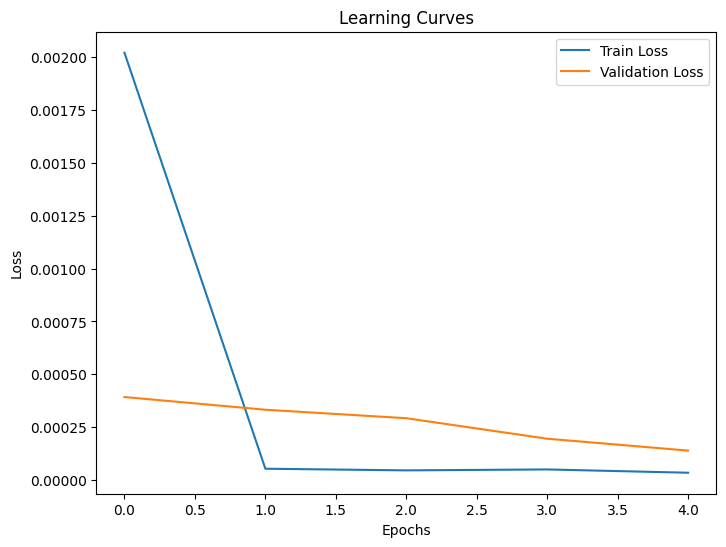

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Learning Curves")
plt.show()